# Classification with the Perceptron, Logistic Regression and Softmax Regression models

Last revision: Tue 28 Dec 2021 6:01:00 AEST

Author: Omar Ghattas

## Introduction

In this lab we will take a closer look at some common classification models used in machine learning. Our focus will be primarily on binary classification (two class problem), but we will also see an example of a k-class problem using softmax regression. 

We begin with a recap of the perceptron classifier and we will work through an example of applying it to simulated data. We will then turn our attention to the logistic regression and softmax regression models and apply them to the famous MNIST dataset. Throughout, we will pay close attention to the `sklearn` implementation of the `LogisticRegression` class.

## Recap: Perceptrons

We begin by taking a look at a very simple model of computation, called the perceptron. Assume that we have $n$ inputs, which we denote by $x_1,x_2,\dots,x_n$, and assume that each $x_i$ is a vector in $p$ dimensions, so that $x_i = [x_{i1}, \dots,x_{ip}]^T$, in other words, we have $p$ features - another way of writing this is: $x_i \in \mathbb{R}^p$ We will always assume that the first feature is a dummy feature, that is $x_{i1} = 1$, to account for the bias term.

Next, we let $w \in \mathbb{R}^p$ be the weight vector for our perceptron model. Note that the dimension of weight vector and the input vector need to be the same. This allows us to compute the dot product:

$$
h_w(x_i) =\langle w, x_i\rangle = \sum_{j=1}^p w_j x_{ij}.
$$

This is known as the activation. Note that the bias (intercept term) here is hidden in $w$. We could have equivalently defined our weight vector by $\tilde{w} \in \mathbb{R}^{p-1}$ and our bias term, $b\in \mathbb{R}$, and written 
$$
h_{\tilde{w},b}(x_i) = b +\sum_{j=2}^p w_j x_{ij},
$$
in other words, $w = (b,\tilde{w})^T$. It doesn't matter which setting you use, they are equivalent, and we will stick with the first one for the remainder.

As discussed in the lecture, the perceptron computes the dot product, and then outputs the sign of this value. The sign (denoted sgn(x) usually) function is defined by 
$$
\text{sgn}(x) = \begin{cases}
+1 \quad &\text{if} \quad x>0\\
0 \quad &\text{if} \quad x=0\\
-1 \quad &\text{if} \quad x<0.
\end{cases}
$$
We can visualise this function:

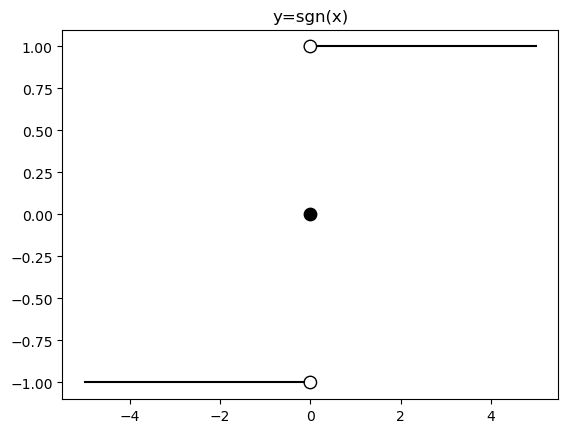

In [1]:
import matplotlib.pyplot as plt
import numpy as np

xx_neg = np.linspace(-5,-0.15,1000)
xx_pos = np.linspace(0.15,5,1000)
plt.plot(xx_neg, np.sign(xx_neg), color='black')
plt.plot(xx_pos, np.sign(xx_pos), color='black')
plt.scatter(0,0, s=80, color='black')
plt.scatter(0,1, s=80, facecolors='none', edgecolors='black')
plt.scatter(0,-1, s=80, facecolors='none', edgecolors='black')
plt.title("y=sgn(x)")
plt.show()

In a binary classification problem, we only have two classes, and so we will usually treat $\text{sgn}(0)=-1$, as in, anything with positive value is classied as $+1$, and anything with non-positive value is classified as $-1$. In other words, we will think of the sgn function as looking like:

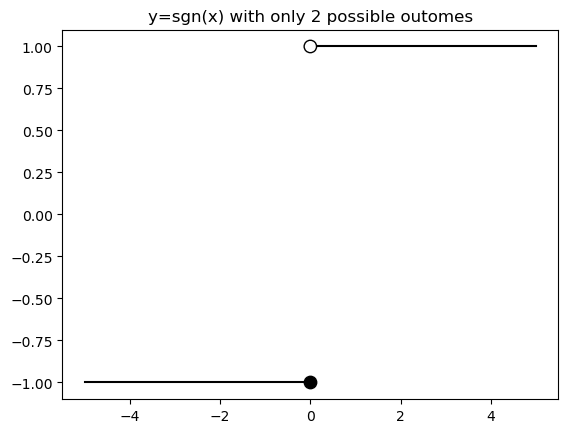

In [2]:
plt.plot(xx_neg, np.sign(xx_neg), color='black')
plt.plot(xx_pos, np.sign(xx_pos), color='black')
plt.scatter(0,-1, s=80, color='black')
plt.scatter(0,1, s=80, facecolors='none', edgecolors='black')
plt.title("y=sgn(x) with only 2 possible outomes")
plt.show()

Now, denote the output of the perceptron on input $x_i$ to be $o(x_i) = \text{sign}(h_w(x_i))$. The idea is to tweak the weight vector $w$ so that $h_w(x_i)$ is positive when $x_i$ has corresponding label $y_i=+1$, and $h_w(x_i)\le 0$ whenever $y_i = -1$. In the next section, we show a simple example for the binary OR function.

Recall that the binary OR function takes in two binary inputs, and returns TRUE if at least one of the two inputs is equal to $1$, and otherwise returns FALSE. For example, if $x = (1,0)$, then 

$$
\text{OR}(x) = \text{TRUE} = +1 = y
$$

and if $x=(0,0)$, then 

$$
\text{OR}(x) = \text{FALSE} = -1 = y.
$$

Note that here we are choosing to encode $\{TRUE, FALSE\} = \{+1,-1\}$. Sometimes we will choose to use the encoding $\{TRUE, FALSE\} = \{+1,0\}$, it doesn't matter, as long as we remember to be consistent.

## Representing simple Boolean functions as a linear classifier

We will first look at modelling a simple two-input Boolean function as linear classifier. We can think of this as a Perceptron WITHOUT any learning! To get started we will use the OR function, for which the truth table will be familiar to you all. Note that you will need to pick some weights for the function to output the correct values given the input. There are many possible values that could do the job. Also, remember to take care with the dimension of the weight vector.

In [3]:
def sgn(x):
    return 1 if x>0 else -1

# set up
X = np.array([[1,0,0],                        # all possible inputs, note that first
              [1,0,1],                        # element is always equal to 1 (bias term)
              [1,1,0], 
              [1,1,1]])     
y = np.array([-1,1,1,1])                      # labels for the OR function OR(x1,x2)
n = X.shape[0]                                # number of data points
m = X[0].shape[0]                             # input dimension
        
w = np.array([-0.03, 0.04, 0.04])              # example weight vector

# what predictions will our current model (w) make?
print("OR Function: ")
for i in range(n):
    h = np.dot(w, X[i])                       # activation
    o = sgn(h)                                # output
    print('For Input', X[i], 'with Class', y[i], 'Predict ', o)

OR Function: 
For Input [1 0 0] with Class -1 Predict  -1
For Input [1 0 1] with Class 1 Predict  1
For Input [1 1 0] with Class 1 Predict  1
For Input [1 1 1] with Class 1 Predict  1


<font color='purple'>
    
#### Exercise: 
Repeat the above analysis but for the AND function, choose an appropriate weight vector by trial and error

## Perceptron Learning

So far, we haven't done any actual learning, we just picked a weight vector, $w$, that works. We now look at an approach to learning $w$ from data. We first recall the (Batch) Perceptron Algorithm from lectures:

\begin{align*}
&\text{input: } (x_1,y_1),\dots, (x_n, y_n)\\
&\text{initialise: } w^{(0)} = (0,0,\dots, 0) \in \mathbb{R}^p\\
&\text{for } t=1,\dots, \texttt{max\_iter}\\
&\qquad \text{if there is an index $i$ such that } y_i \langle w^{(t)}, x_i \rangle \le 0:\\
&\qquad \qquad   w^{(t+1)} = w^{(t)} + y_i x_i\\
&\qquad     \text{else:}\\
&\qquad \qquad \text{ output } w^{(t)}, t\\
\end{align*}

The perceptron is known as a mistake driven algorithm, since it updates $w$ only when a mistake is made (i.e. when $y_i \langle w, x_i \rangle \le 0$). It is also important to note that the perceptron only converges when it makes no mistakes on the data, so in other words, this algorithm can only terminate if the data set is linearly separable. We can implement the above in code and try to visualise the learning process.

First, some helper functions to generate toy data and plot the perceptron at each iteration.

In [4]:
def generate_data(n=20, means=[[3,3],[-1,1]], seed=1):
    '''
    generate data from two gaussians
    '''
    np.random.seed(seed)
    m1 = np.array(means[0])
    m2 = np.array(means[1])
    S1 = np.random.rand(2,2)
    S2 = np.random.rand(2,2)
    dist_01 = np.random.multivariate_normal(m1, S1.T @ S1, n)
    dist_02 = np.random.multivariate_normal(m2, S2.T @ S2, n)
    X = np.concatenate((np.ones(2*n).reshape(-1,1), 
                        np.concatenate((dist_01, dist_02))), axis=1)
    y = np.concatenate((np.ones(n), -1*np.ones(n))).reshape(-1,1)
    shuffle_idx = np.random.choice(2*n, size=2*n, replace=False)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y

def plot_perceptron(ax, X, y, w):
    pos_points = X[np.where(y==1)[0]]
    neg_points = X[np.where(y==-1)[0]]
    ax.scatter(pos_points[:, 1], pos_points[:, 2], color='blue')
    ax.scatter(neg_points[:, 1], neg_points[:, 2], color='red')
    xx = np.linspace(-6,6)
    yy = -w[0]/w[2] - w[1]/w[2] * xx
    ax.plot(xx, yy, color='orange')
    
    ratio = (w[2]/w[1] + w[1]/w[2])
    xpt = (-1*w[0] / w[2]) * 1/ratio
    ypt = (-1*w[0] / w[1]) * 1/ratio
    
    ax.arrow(xpt, ypt, w[1], w[2], head_width=0.2, color='orange')
    ax.axis('equal')

Next, we implement the perceptron learning algorithm. Note here that we will randomly initiliase the weight vector rather than taking the weight vector to be $(0,0,\dots,0)$, this is done to make it easier to visualise the algorithm. Note we also restrict attention to the two dimensional case, so $w \in \mathbb{R}^3$ to account for the two dimensions and the bias (intercept) term.

In [5]:
def train_perceptron_for_vis(X, y, max_iter=100):
    np.random.seed(20)                          # for consistency in weight init
    w = np.random.random(3)                     # init weights randomly
    ctr = 0                                     # keep track of number of iterations
    for _ in range(max_iter):
        
        yXw = (y * X) @ w.T                     # compute all predictions made by model
        mistake_idxs = np.where(yXw <= 0)[0]     # find indexes where mistake is made
        if mistake_idxs.size > 0:
            ctr += 1
            i = np.random.choice(mistake_idxs)  # pick idx randomly
            w = w + y[i] * X[i]                 # update w
            
            # visualisation
            fig, ax = plt.subplots()
            plot_perceptron(ax, X, y, w)
            plt.show()
            print(f"Iteration {ctr}: w = {w}")
        
    # plot final weight vector
    fig, ax = plt.subplots()
    plot_perceptron(ax, X, y, w)
    plt.show()
    print(f"Iteration {ctr}: w = {w}")

    return 

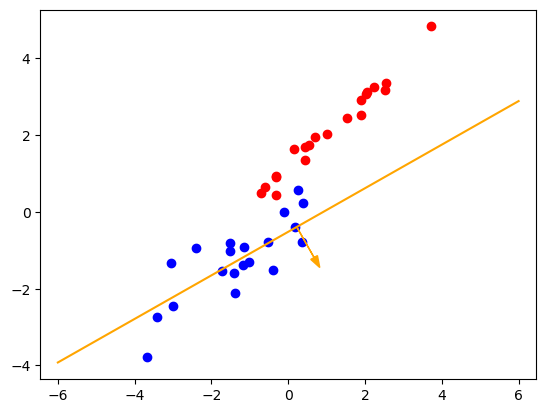

Iteration 1: w = [-0.4118692   0.45148601 -0.79584122]


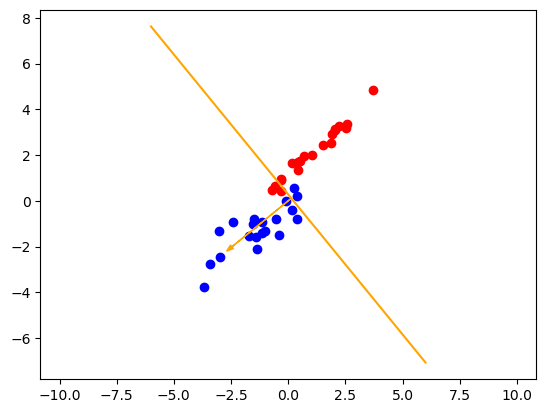

Iteration 2: w = [ 0.5881308  -2.59682971 -2.12119882]


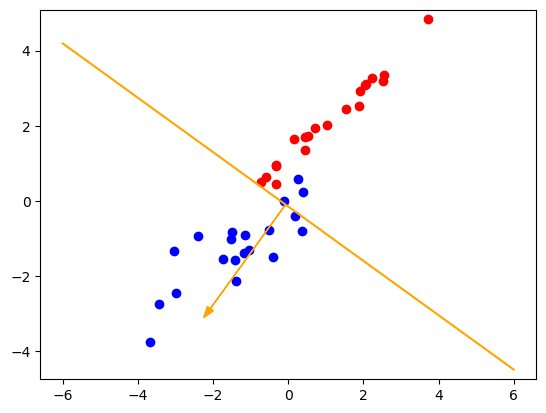

Iteration 3: w = [-0.4118692  -2.00249179 -2.76919429]


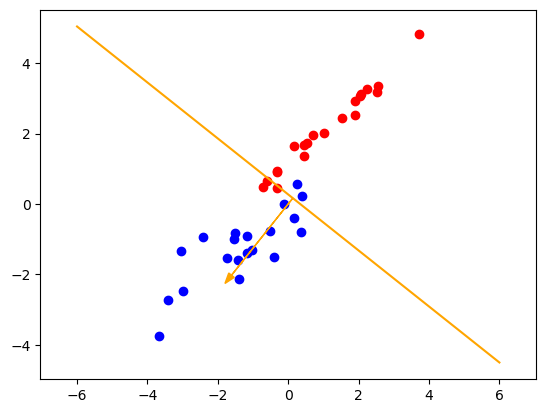

Iteration 4: w = [ 0.5881308  -1.74183941 -2.18951439]


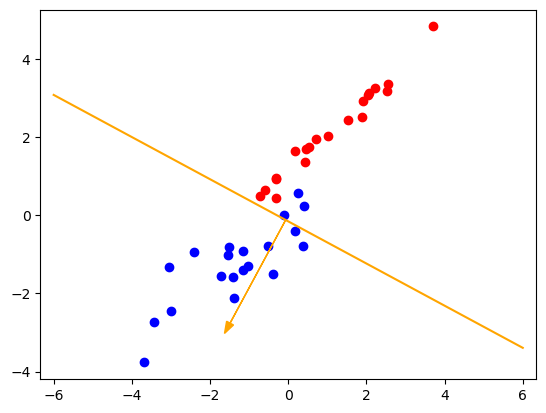

Iteration 5: w = [-0.4118692  -1.42242212 -2.63810207]


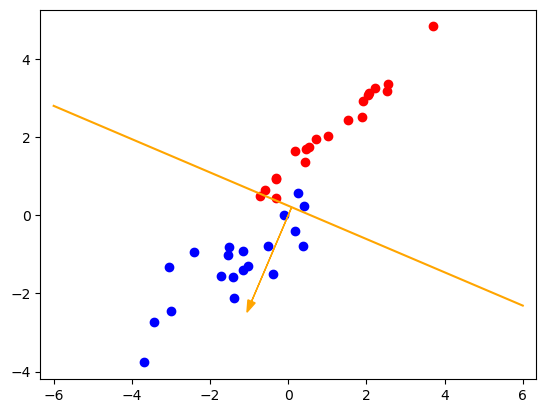

Iteration 6: w = [ 0.5881308  -1.02625027 -2.41014956]


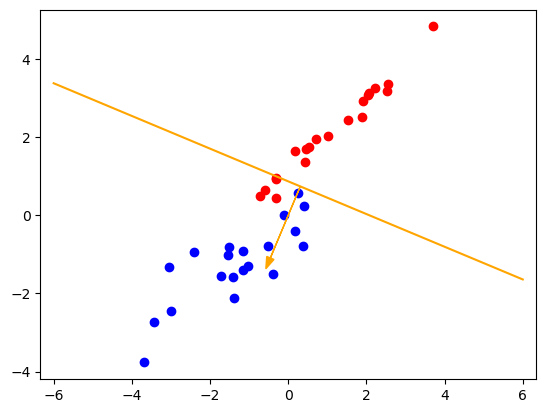

Iteration 7: w = [ 1.5881308  -0.76559789 -1.83046966]


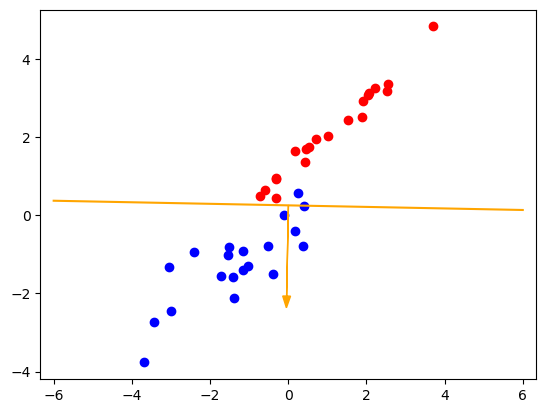

Iteration 8: w = [ 0.5881308  -0.04577813 -2.32033579]


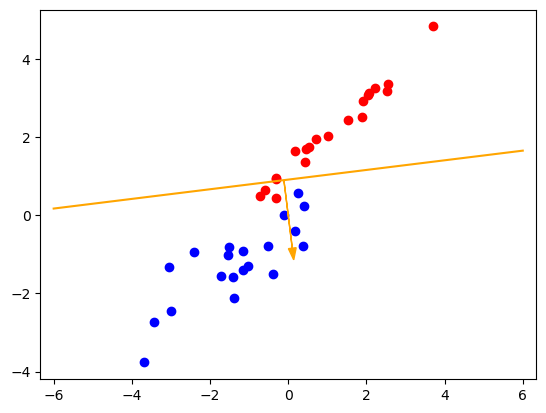

Iteration 9: w = [ 1.5881308   0.21487424 -1.74065589]


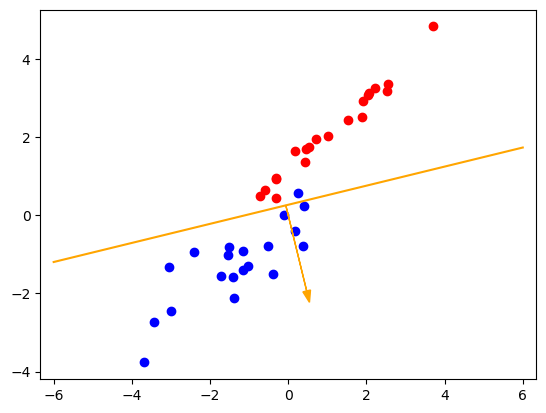

Iteration 10: w = [ 0.5881308   0.53429153 -2.18924357]


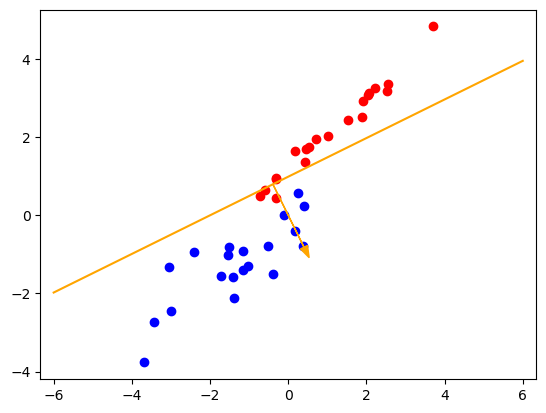

Iteration 11: w = [ 1.5881308   0.79494391 -1.60956368]


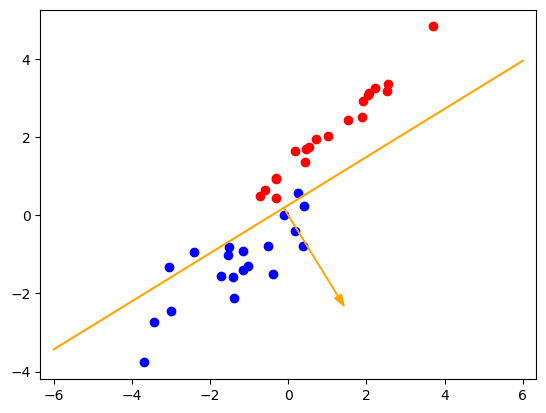

Iteration 12: w = [ 0.5881308   1.38928183 -2.25755914]


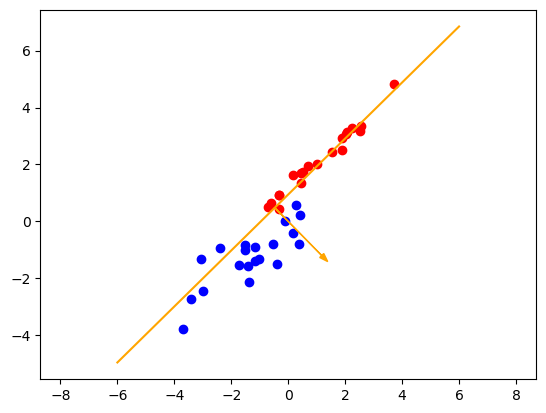

Iteration 13: w = [ 1.5881308   1.6499342  -1.67787925]


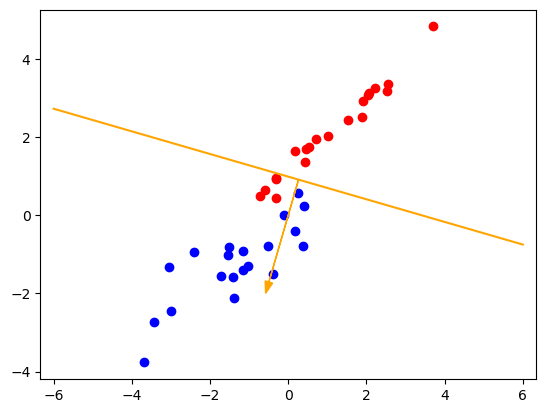

Iteration 14: w = [ 2.5881308  -0.75825596 -2.61905618]


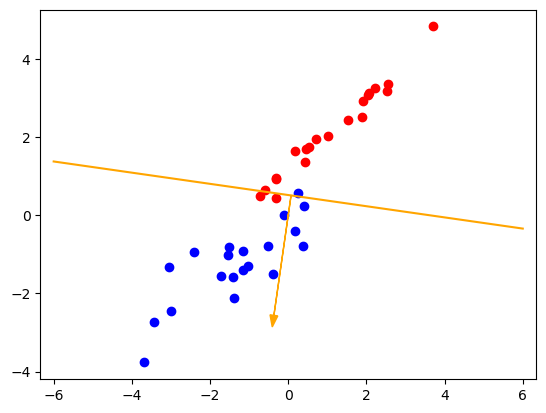

Iteration 15: w = [ 1.5881308  -0.43883867 -3.06764386]


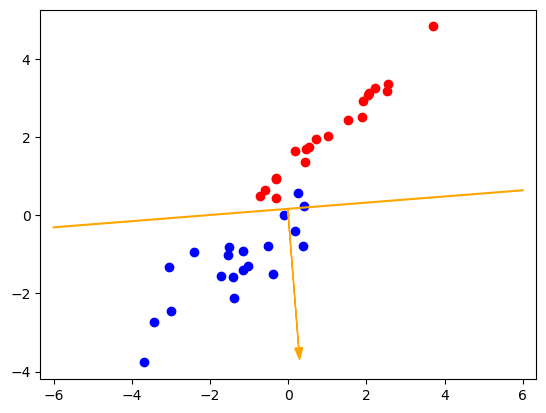

Iteration 16: w = [ 0.5881308   0.28098109 -3.55750999]


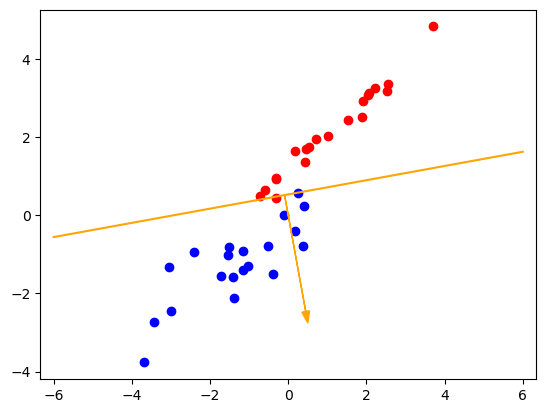

Iteration 17: w = [ 1.5881308   0.54163347 -2.97783009]


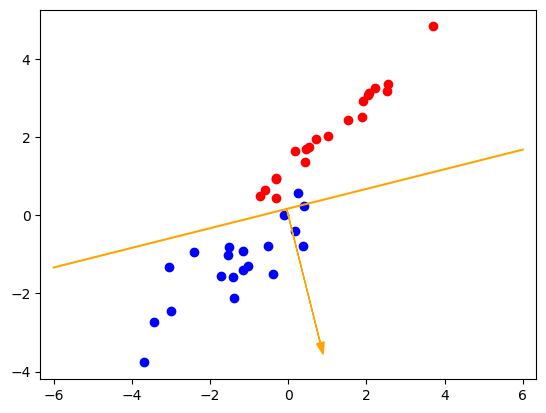

Iteration 18: w = [ 0.5881308   0.86105076 -3.42641778]


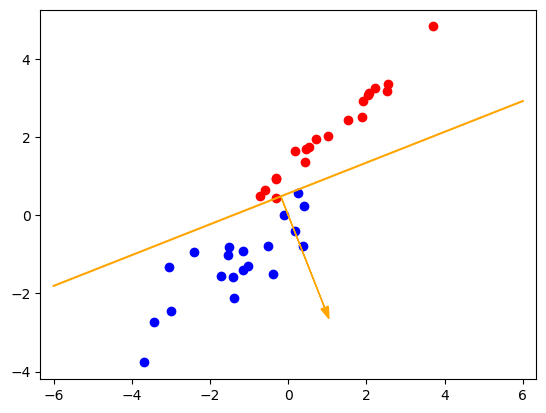

Iteration 19: w = [ 1.5881308   1.12170313 -2.84673788]


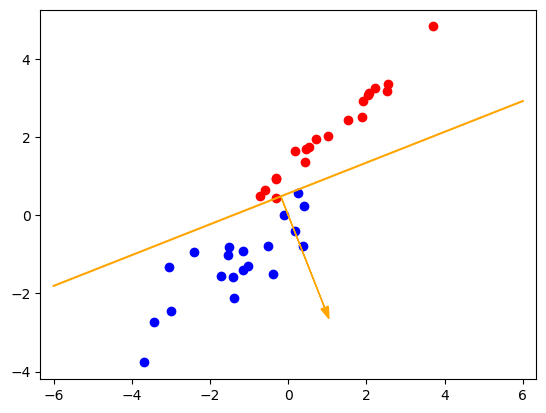

Iteration 19: w = [ 1.5881308   1.12170313 -2.84673788]


In [6]:
X, y = generate_data(n=20, means=[[-1,-1], [1,2]], seed=204)
train_perceptron_for_vis(X, y)

Note that in the implementation we relied on matrix algebra to make life easier. Namely, instead of computing $y_i \langle w, x_i \rangle$ for each data point, we can compute this in one go by noting that the design matrix is
$$
X = \begin{bmatrix}
    x_1^T\\ x_2^T\\\vdots\\x_n^T
\end{bmatrix} \in \mathbb{R}^{n \times 3},
$$
$y \in \mathbb{R}^n$ and $w \in \mathbb{R}^3$, so 
$$
y \odot Xw = 
y \odot \begin{bmatrix}
    \langle x_1, w \rangle\\ \langle x_2, w \rangle\\\vdots\\ \langle x_n, w \rangle
\end{bmatrix}=
\begin{bmatrix}
    y_1 \langle x_1, w \rangle\\ y_2 \langle x_2, w \rangle\\\vdots\\y_n \langle x_n, w \rangle
\end{bmatrix}
$$

where $\odot$ is called the Hadamard, or pointwise product, and denotes the elementwise multiplication of two vectors. From here, we can simply check which indices we are making mistakes on by checking which elements of this vector are negative.

## Binary Classification with Logistic Regression
The perceptron classifier is perhaps the most simple type of binary classifier. One of the most popular approaches to doing classification in practice however is the Logistic Regression model. In the tutorial this week, we will take a deep look at the theory behind logistic regression. Here, we will be more interested in how logistic regression can be applied to real data problems. We will specifically look at:

1. The `sklearn` logistic regression implementation
2. Applying logistic regression to MNIST data
3. Common performance metrics used when performing classification

Further, we will look at:

4. Softmax Regression: An extension of logistic regression (used only for binary classification) to multi-label classification

The discussion of logistic regression here is important for two reasons, first we are going to be continuing our exploration of the `sklearn` library, and second we will be working with logistic and softmax regressions, which can be thought of as the simplest type of neural network, and so having a deep understanding of the content here will be very helpful to you in later weeks.

#### MNIST Dataset
First we introduce one of the most famous datasets used in machine learning: MNIST. MNIST is often referred to as the `Hello, World!` of Machine Learning. The MNIST dataset is comprised of images of handwritten numbers (0-9), so it has a total of $10$ classes. When doing logistic regression we will only use two labels (any subset of 2 of the 10 available labels in MNIST). The MNIST digits are represented by a a $28 \times 28$ array (images), and so we have $28 \times 28 = 784$ features in total.

We can load MNIST in a number of ways, but see we already have some experience with the `PyTorch` module from the previous lab, we will use it to load in the data. `PyTorch` gives us an easy way to apply transformations to the data and create a `DataLoader` object that makes training models more straight forward. We will discuss the `DataLoader` object in more detail a little later on in the course when we start working with neural nets.

The following code loads in the MNIST data, here we have both a train data set and a test data set.

In [ ]:
import torchvision                                        #! pip3 install torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trainset = MNIST(root = './', train=True, download=True, transform=transform)
testset = MNIST(root = './', train=False, download=True, transform=transform)

Let's take a minute to understand these objects:

In [ ]:
# size of datasets
print(f"Number of observations in train set: {trainset.data.shape[0]}")
print(f" Number of observations in test set: {testset.data.shape[0]}")

# plotting an image in the dataset using imshow()
idx = 2489
plt.imshow(trainset.data[idx], cmap='gray')
plt.title(trainset.targets[idx])
plt.show()

### Logistic Regression with Sklearn

In the tutorial this week, we define the logistic regression problem as the problem of minimizing the cross entropy loss:

\begin{align*}
\hat{\beta}, \hat{\beta}_0 &= \arg \min_{\beta, \beta_0}  \mathcal{L}(\beta, \beta_0)\\
&= \arg \min_{\beta, \beta_0 \in \mathbb{R}^p} 
-\left [ 
     \sum_{i=1}^n y_i \ln \left (\frac{1}{1+e^{-\beta^T x_i - \beta_0}} \right) + (1-y_i) \ln \left (1-\frac{1}{1+e^{-\beta^T x_i - \beta_0}} \right)
\right]
\end{align*}

where $y_i \in \{0,1\}$ is binary valued and represents the label associated with the input $x_i$. In pratice however, we usually work with the following regularized version:

\begin{align*}
\hat{\beta}, \hat{\beta}_0 &= \arg \min_{\beta, \beta_0}  C\mathcal{L}(\beta, \beta_0) + \text{Penalty}(\beta),
\end{align*}

where Penalty$(\beta)$ is a penalty/regularization term applied to the weight vector $w$. For example, $\text{Penalty}(\beta) = \|\beta\|_1$ when we want to apply $\ell_1$ regularization to $w$ (this would be the logistic version of the LASSO). Note that we not usually penalize the intercept/bias term $w_0$. Note also the introduction of the hyper-parameter $C$, which does a similar job to $\lambda$ in the lasso/ridge regression model formulations..

<font color='purple'>
    
#### Exercise

Consider the `sklearn` <a href ="https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression">logistic regression implementation (Section 1.1.11)</a> which claims to minimize the following objective:
        \begin{align}
            \hat{w}, \hat{c} =\arg \min_{w, c} \left[\|w\|_1 + C \sum_{i=1}^n \log (1+ \exp (-\tilde{y}_i(w^T x_i + c))) \right ].
        \end{align}
        It turns out that this objective is identical to our objective above, but only after re-coding the variables to be in $\{-1,1\}$ instead of binary values $\{ 0,1\}$. That is, $\tilde{y}_i \in \{-1,1\}$, whereas $y_i \in \{0,1 \}$. Argue rigorously that the two objectives are identical, in that they give us the same solutions ($\hat{\beta}_0 = \hat{c}$ and $\hat{\beta} = \hat{w}$). Further, describe the role of $C$ in the objectives, how does it compare to the standard LASSO parameter $\lambda$?

We next create train, validation and test sets to run logistic regression on - these will be comprised of only the class1 and class2 images in MNIST (to be determined in the code). Logistic regression expects a vector input and so treats the $28 \times  28$ image as a flattened 784 dimensional vector. Obviously in practice we would want to account for the spatial properties of the input images, but for here we will ignore those. 

We will take our train set to be 60\% of the available images, whereas the validation and test sets will be 20\% each. We will also convert the tensor datasets to numpy arrays.

To make the problem more challenging for the model, we will work with a smaller sample of size `nSample` and we will also randomly choose a subset of $s$ features and omit the rest.

In [ ]:
from sklearn.model_selection import train_test_split

# sample size and features to work with
s = 40                                                                    # reduced features to work with 
sFeatures = np.random.choice(np.arange(784), size=s, replace=False)       # choose s features randomly from the 784
sFeatures.sort()
nSample = 1000


# choose two class labels
class1Label = 0
class2Label = 1

class1Images = trainset.data[trainset.targets==class1Label].reshape(-1,784).numpy()      # images with class1
class2Images = trainset.data[trainset.targets==class2Label].reshape(-1,784).numpy()      # images with class2

# work with a smaller sample size
class1Images = class1Images[:nSample, sFeatures]
class2Images = class2Images[:nSample, sFeatures]
X = np.concatenate((class1Images, class2Images), axis=0)
y = np.concatenate((np.zeros(class1Images.shape[0]), np.ones(class2Images.shape[0])))

# create Xtrain, Xvalid, Xtest
Xtrain, X_, ytrain, y_ = train_test_split(X, y, test_size=0.4, shuffle=True)
Xvalid, Xtest, yvalid, ytest = train_test_split(X_, y_, test_size=0.5, shuffle=True)

print(f'Xtrain shape = {Xtrain.shape}')
print(f'Xvalid shape = {Xvalid.shape}')
print(f'Xtest  shape = {Xtest.shape}')

<font color='purple'>
    
#### Exercise

In order to choose the correct value of the hyper-parameter $C$, we will use K-fold cross validation. As always, we use the validation set to do any form of hyper-parameter tuning.
    
Create a grid fo 100 $C$ values ranging from $C=0.0001$ to $C=1$ in equally sized increments. Use the  <a href ="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">`sklearn.model_selection.GridSearchCV` </a> to do the grid search cross validation using your parameter grid. For the `estimator` argument, use the `sklearn.linear_model.LogisticRegression` model with `l1` penalty and `liblinear` solver and find the optimal value of $C$ when performing 10-fold cross validation using `neg_log_loss` scoring. Fit your logistic model with the chosen $C$ value. Report train and test accuracy.
    
Further, explain why it is a bad idea to tune hyper-parameters using the test set.

<font color='green'>

The test set is an independent clean dataset that we test our final model on. If we were to use it to tune the hyperparameters of our model then we would be using the test set to both tune our model and test our model, and is likely to result in overfitting.

#### An important distinction: predict_proba vs. predict
Many classification models in `sklearn` (not just logistic regression) have two methods that can be somewhat confusing to students, so let's make sure we understand what each of these methods does and when to use each one. In what follows, let's assume we called our logistic model `logistic_mod`. Then, recall that a logistic regression is a type of regression, meaning it outputs a probability that an input belongs to a particular class (the class coded as $y=1$). In order to turn this into a classifier, we use a threshold value $t$ (known as the discrimination threshold) and classify any probabilty that is $t$ or greater as belonging to class $y=1$, and $y=0$ otherwise. The choice of $t$ is up to the modeller, and the default value is $t=0.5$. 

With this in mind, the `predict_proba()` method returns the predicted probability that the model returns for a particular input, whereas `predict()` returns the predicted class. If we are solely interested in model accuracy, then two different models that have the same predicted labels will be of equal value to us. However, the accuracy can be a crude way of comparing models. 

For example, consider two models: m1 and m2. Let's say we have inputs `[x1,x2,x3,x4]` with labels $[1, 0, 0, 0]$ and the following holds:

```
m1.predict([x1,x2,x3,x4]) = [1,0,0,0]
m2.predict([x1,x2,x3,x4]) = [1,0,0,0]
```

So both models have 100\% accuracy. However, let's say we also get:

```
m1.predict_proba([x1,x2,x3,x4]) = [[0.1, 0.9],
                                   [0.99, 0.01]
                                   [0.9, 0.1],
                                   [0.92, 0.08]]
m2.predict_proba([x1,x2,x3,x4]) = [[0.49, 0.51] ,
                                   [0.51, 0.49],
                                   [0.52, 0.48],
                                   [0.51, 0.49]]
```
The `predict_proba` method returns the predicted probability for each class, which is why there are two numbers for each `xi`.

Now, clearly m1 is able to discriminate the positive and negative classes much more effectively than m2, but the two models would be equivalent in terms of accuracy score. If we are more interested in the ability of a model to discriminate between two classes, we would consider different metrics, such as the cross entropy loss (see tutorial this week), which is also called the log-loss, and is implemented in `sklearn.metrics.log_loss`. From tutorials, we know that the cross entropy measures the distance between a predicted probability and the truth, and is defined by

$$
\mathcal{L}(w) = -\sum_{i=1}^n (y_i \ln \hat{p}_i + (1-y_i) \ln(1-\hat{p}_i)).
$$

In our toy example,

```
ll_m1 = log_loss([1,0,0,0], m1.predict_proba([x1,x2,x3,x4])) = 0.0760
ll_m2 = log_loss([1,0,0,0], m2.predict_proba([x1,x2,x3,x4])) = 0.6685
```

So the log-loss of m1 is much lower than that of m2, and we would prefer m1 if our criteria is log-loss and not accuracy.

#### The Trade-Off between TPR (Sensitivity) and TNR (Specificity)
A binary classifier can have one of four possible outcomes:
1. True Positive (TP): classifier predicts $\hat{y}=1$ when true label is $y=1$
2. False Positive (FN): classifier predicts $\hat{y}=1$ when true label is $y=0$
3. True Negative (TN): classifier predicts $\hat{y}=0$ when true label is $y=0$
4. False Negative (FN): classifier predicts $\hat{y}=0$ when true label is $y=1$

True positives and True negatives are clearly good, whereas false positives and false negatives are obviously not so good. Two good examples to keep in mind are:

Example 1 (CANCER DETECTION): You build a classifier that looks at the output of some costly medical test and attempts to predict whether patient has a rare form of cancer and needs further testing ($y=1$) or no cancer ($y=0$). The goal here is to save as many lives as possible.

Example 2 (MARKETING CAMPAIGN): You work for a bank and wish to identify new customers to send ads to about a new credit card. The classifier identifies a potential customer and sends them a targeted ad via email ($y=1$) or labels them as not a potential customer ($y=0$). The goal here is to increase the revenue stream of the bank.

<font color='purple'>

#### Exercise
    
Discuss Examples 1 and 2, are false positives and false negatives equally as bad in both cases?

We define the following terms, each of which (somewhat annoyingly) has many names in the literature:

- True Positive Rate (TPR), Sensitivity, Recall: $\text{TPR} = \frac{\text{TP}}{\text{P}} = \frac{\text{TP}}{\text{TP} + \text{FN}}$ where $P$ is the actual number of positive values in the data.
- True Negative Rate (TNR), Specificity, Selectivity: $\text{TNR} = \frac{\text{TN}}{\text{N}} = \frac{\text{TN}}{\text{TN} + \text{FP}}$ where $N$ is the actual number of negative values in the data.

Any good classifier should ideally have a large TPR and a large TNR, but unfortunately, there is a trade-off between the two. To see this, consider the following exercise.

<font color='purple'>
    
#### Exercise
Consider fitting logistic regression models to the cancer detection problem discussed earlier. Once you fit your model, you need to choose the discrimination parameter $t$. Explain what happens at the extremes $t=0$ and $t=1$. Explain the trade-off between TPR and TNR as $t$ increases.

The Receiver Operator Characteristic (ROC) curve is a graphical depiction of what happens to the TPR and FPR = 1-TNR as we vary the threshold $t$. It is a good way of comparing different classification models. Let's consider a couple of logistic regression models fit to the MNIST problem but with different $C$ values, and compare them by looking at their ROC curves. The Area Under the Curve (AUC) gives us a nice summary of how good a particular model is, it is the area under each of the ROC curves.

In [1]:
from sklearn.metrics import roc_curve, roc_auc_score

# choosing C via cross validation then computing FPR and TPR at all thresholds
logistic_mod_1 = LogisticRegression(penalty='l1',  solver='liblinear', C=Cbest).fit(Xtrain, ytrain)
mod_1_preds = logistic_mod_1.predict_proba(Xtest)[:,1]        # note, predictions need to be just for one of the classes
fpr_1, tpr_1, _ = roc_curve(ytest, mod_1_preds)
auc_1 = roc_auc_score(ytest, mod_1_preds)

# choosing C small
logistic_mod_2 = LogisticRegression(penalty='l1', solver='liblinear', C=0.02).fit(Xtrain, ytrain)
mod_2_preds = logistic_mod_2.predict_proba(Xtest)[:,1]
fpr_2, tpr_2, _ = roc_curve(ytest, mod_2_preds)
auc_2 = roc_auc_score(ytest, mod_2_preds)

# choosing C to be very large (no regularization)
logistic_mod_3 = LogisticRegression(solver='liblinear', C=1000).fit(Xtrain, ytrain)
mod_3_preds = logistic_mod_3.predict_proba(Xtest)[:,1]
fpr_3, tpr_3, _ = roc_curve(ytest, mod_3_preds)
auc_3 = roc_auc_score(ytest, mod_3_preds)


fig = plt.figure(figsize=(10,10))
plt.plot(fpr_1, tpr_1, label="model 1, AUC="+str(auc_1))
plt.plot(fpr_2, tpr_2, label="model 2, AUC="+str(auc_2))
plt.plot(fpr_3, tpr_3, label="model 3, AUC="+str(auc_3))
plt.ylabel("True Positive Rate (TPR)")
plt.xlabel("False Positive Rate (FPR)")
plt.title("ROC Curves for Three Logistic Models")
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'sklearn'

Some things to note:

1. The ultimate model would have a TPR and a TNR set to 1, or equivalently the TPR set to 1 and the FPR set to 0, so the closer that the models are to the top-left corner of the plot, the better.
2. All three models seem to be quite poor at this task. 
3. At a given threshold, there is no guarantee that one model is better than the other.
4. The AUC provides a nice summary score that we can use to compare the models. You can think of the AUC as the average FPR/TPR trade-off over all possible discrimination thresholds.


## Multi-class classification - Softmax Regression

In Softmax Regression, we allow the label to take on one of $K$ possible values, so given an input $x$, we would like to estimate $P(Y=k|x)$ for $k=1,\dots, K$. The model must therefore output a $K$ dimensional vector of probabilities whose elements sum to $1$, i.e. 

\begin{align*}
h(x) = 
\begin{bmatrix}
P(y=1|x) \\ P(y=2|x)\\ \vdots \\ P(y=K|x)
\end{bmatrix}
\end{align*}

We will not go into the mathematical details of how softmax regression is derived (for those that are interested, it is similar to the logistic regression case, but using the multinomial distribution instead of the bernoulli). We will however give a short motivation for how the probabilities are estimated.

#### Short motivation for softmax regression 
Recall (from lectures and tutorial this week) that in the logistic regression problem (binary $y$), we wish to estimate a probability: $P(y=1|x)$. One approach is to use a linear model:

$$
P(y=1|x) = w^T x,
$$

where $w$ is a parameter vector that we estimate. The problem with this however is that a probability must be in the range $[0,1]$, whereas $w^T x \in (-\infty, \infty)$. A solution is to then wrap the linear model in a logistic sigmoid:

$$
P(y=1|x) = \sigma(w^T x) = \frac{1}{1+e^{-w^T x}},
$$

which guarantees that our estimated probability is actually a probability, regardless of the choice of $w$. Let's extend this idea to the multi-class case: assume that for each class we have a $p$-dimensional vector $\theta_1 \in \mathbb{R}^p, \theta_2 \in \mathbb{R}^p, \dots, \theta_K \in \mathbb{R}^p$, so we have a total of $Kp$ unkown parameters to be estimated, and we will stack these unkown vectors into a single matrix for brevity:

$$
\Theta = [\theta_1,\dots, \theta_K] \in \mathbb{R}^{p \times K}.
$$

Now, we want to estimate $K$ probabilities, so we could just do the linear model approach:

\begin{align*}
P(y=1|x) &= \theta_1^T x\\
P(y=2|x) &= \theta_2^T x\\
& \vdots\\
P(y=K|x) &= \theta_K^T x
\end{align*}

in which case we run into the same issue that each term is not guaranteed to be a probability. We can use the same trick of using the logistic sigmoid:

\begin{align*}
P(y=1|x) &= \sigma(\theta_1^T x)\\
P(y=2|x) &= \sigma(\theta_2^T x)\\
& \vdots\\
P(y=K|x) &= \sigma(\theta_K^T x).
\end{align*}

Which seemingly fixes the problem - but we are faced with another problem now, there is no guarantee that the sum of the probabilities add up to one. An easy fix is to normalize the probabilities by their sum:

\begin{align*}
P(y=1|x) &= \frac{\sigma(\theta_1^T x)}{\sum_{j=1}^k \sigma(\theta_j^T x)}\\
P(y=2|x) &= \frac{\sigma(\theta_2^T x)}{\sum_{j=1}^k \sigma(\theta_j^T x)}\\
& \vdots\\
P(y=K|x) &= \frac{\sigma(\theta_K^T x)}{\sum_{j=1}^k \sigma(\theta_j^T x)}.
\end{align*}

This ensures two things:
1. each element is a valid probability (it has to be between $0$ and $1$.
2. the sum of the estimated probabilities is 1.

Our softmax regression model therefore takes the form:

\begin{align*}
h_\Theta (x) = 
\begin{bmatrix}
P(y=1|x) \\ P(y=2|x)\\ \vdots \\ P(y=K|x)
\end{bmatrix}
=
\frac{1}{ \sum_{j=1}^k \sigma(\theta_j^T x)}
\begin{bmatrix}
\sigma(\theta_1^T x)\\
\sigma(\theta_2^T x)\\
\vdots \\
\sigma(\theta_K^T x)
\end{bmatrix}
\end{align*}

and we now have a parameter matrix $\Theta$ to estimate. What remains is to define the loss function we will use for the problem. Recall in the logistic case the loss function is:

\begin{align*}
\mathcal{L} (w)
&= -\sum_{i=1}^n (y_i \ln \hat{p}_i + (1-y_i) \ln(1-\hat{p}_i))\\
&= -\sum_{i=1}^n (y_i \ln P(y_i = 1|x_i) + (1-y_i) \ln P(y_i = 0|x_i),
\end{align*}

and noting that $y_i = 0$ or $y_i = 1$, we can rewrite this as 
\begin{align*}
\mathcal{L} (w)&= -\sum_{i=1}^n \sum_{j=0}^1 \mathbf{1}\{y_i = j \} \ln P(y_i = j|x_i),
\end{align*}

where $ \mathbf{1}\{y_i = j \}$ is an indicator variable, which simply takes the value $1$ if the term inside the brackets is true, and zero otherwise. For example $\mathbf{1}\{ 1+2=3\} = 1$. Now, the reason we wrote the loss this way is that it allows us to generalize to the softmax regression problem in the following way:

\begin{align*}
\mathcal{L}(\Theta) 
&= -\sum_{i=1}^n \sum_{j=0}^K \mathbf{1}\{y_i = j \} \ln P(y_i = j|x_i)\\
&= -\sum_{i=1}^n \sum_{j=0}^K \mathbf{1}\{y_i = j \} \ln \frac{\sigma(\theta^T_j x_i)}{\sum_{k=1}^K \sigma(\theta^T_k x_i)}.
\end{align*}

#### Softmax Regression in sklearn
Luckily for us, the `sklearn` logistic regression implementation handles softmax regression automatically. In this section we will demonstrate its performance on the full MNIST dataset. We first create our dataset in the usual way:

In [ ]:
# subsample the data to make it more manageable
nSample = 2000
idxsTrain = np.random.choice(np.arange(trainset.data.shape[0]), size=nSample, replace=False)
idxsTest = np.random.choice(np.arange(testset.data.shape[0]), size=nSample//5, replace=False)

Xtrain = trainset.data.reshape(-1, 784).numpy()[idxsTrain, :]
Xtest = testset.data.reshape(-1, 784).numpy()[idxsTest, :]            
ytrain = trainset.targets.numpy()[idxsTrain]
ytest = testset.targets.numpy()[idxsTest]

print(f'Xtrain shape = {Xtrain.shape}')
print(f'Xtest  shape = {Xtest.shape}')

<font color='purple'>
    
#### Exercise
As mentioned earlier, `sklearn` handles softmax regression easily using the same `LogisticRegression` object as used for the binary regression problem, with an added argument `multi_class` which controls whether we fit a binary logistic or a softmax regression (also referred to as multinomial logistic regression). If we set `multi_class=ovr`, it fits a single logistic to every single label (i.e. $K$ standard logistic fits), whereas if we set `multi_class=multinomial`, we will get a softmax regression fit. Note that the `multi_class=multinomial` is not compatible with the `solver=liblinear` setting.
    
Fit a multinomial regression to the entire MNIST dataset using the `sag` solver and `l2` regularization with `C=50` (you may need to increase the `max_iter` to 1000 here), additionally you can increase the `tol` argument to `0.001` for faster convergence. Use the `sklearn.metrics.confusion_matrix`, produce a confusion matrix (on the test set) to display your results.

<font color='purple'>
    
#### Exercise
Recall that the softmax regression requires estimation of $Kp$ parameters, one $p$-dimensional vector for each of the $K$ classes. For the MNIST problem, that means we have $10 \times 784$ parameters in total. Create a $2 \times 5$ grid of plots (one for each of the 10 MNIST classes), and use `plt.imshow()` to plot the estimated coefficient vector $\theta_k$. Note that you will have to reshape each coefficient vector into the $28 \times 28$ original format of MNIST to see anything interesting. What do you observe?

<font color='purple'>
    
#### Exercise
In some cases, we would like a single metric to summarize the performance of a model as opposed to having a confusion matrix. The most commonly used (and readily available in `sklearn.metrics`) metrics are the precision, recall and F1 scores. Read the following to gain an understanding of these metrics:

https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
    
Further, read the following post to understand the difference between micro and macro versions of these metrics:
    
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin